<a href="https://colab.research.google.com/github/Oukey/M_L/blob/master/myML1_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Занятие 7. Использование предобученных моделей (transfer learning)**

https://vk.com/lambda_brain


---




Разберём прикладной пример из туториалов PyTorch
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

Проблема многих задач реального мира в том, что большие и качественные датасеты для них подобрать сложно, а сам процесс обучения с нуля занимает много времени и вычислительных ресурсов и в целом обходится весьма дорого. Да и придумать, сконструировать эффективную модель -- обычно серьёзная научная задача.

На помощь приходит **transfer learning** -- концепция, когда мы используем предобученные модели для решения схожих задач. В целом transfer learning весьма чётко отстраивается от стандартных задач машинного обучения и подразумевает различные техники корректировки уже существующих моделей. Например, популярная практика -- задействовать свёрточные сети, которые были обучены на классическом датасете ImageNet (миллион с лишним изображений, тысяча классов, http://www.image-net.org ), и немного допилить их под свою специфическую задачу.


---

Основные подходы к transfer learning такие: 

-- сеть мы будем обучать не с нуля, а с уровня уже предобученной на ImageNet сети;

-- веса всей этой сети мы заморозим, и только самый последний Linear-слой с полным подключением заменим своим, и только этот слой и обучим с нуля.


---

Чему будем обучать? Например, мы хотим расширить способность нейросети распознавать муравьёв и пчёл. У нас имеется некая универсальная модель, обученная на ImageNet, и в данном случае не важно, имеются ли в ней собственные классы "муравьи" и "пчёлы" -- если они и есть, то из-за универсальности модели точность наверняка не очень высокая. Главное, что у нас есть большое основание предполагать, что эта сеть должна справиться с нашей задачей успешно, потому что её точность распознавания других подобных объектов реального мира весьма высока.

Ещё один важный нюанс в том, что у нас будет совсем небольшой оригинальный датасет -- по 120 обучающих и 75 тестовых изображений на каждый класс. С нуля качественно обучить нейросеть на таком объёме данных практически нереально.





---

Сперва нам надо локально скопировать этот небольшой датасет. Выполним соответствующие системные команды: 





In [1]:
!mkdir -p "data"
!wget -N https://download.pytorch.org/tutorial/hymenoptera_data.zip -P "data"
!unzip -o data/hymenoptera_data.zip -d data/


--2019-09-21 16:43:01--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.226.42.62, 13.226.42.64, 13.226.42.10, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.226.42.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘data/hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  74.7MB/s    in 0.6s    

2019-09-21 16:43:02 (74.7 MB/s) - ‘data/hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  data/hymenoptera_data.zip
   creating: data/hymenoptera_data/
   creating: data/hymenoptera_data/train/
   creating: data/hymenoptera_data/train/ants/
  inflating: data/hymenoptera_data/train/ants/0013035.jpg  
  inflating: data/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: data/hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: data/hymenoptera_data/train/ants/1099452230

Датесет будет распакован в локальный каталог data/hymenoptera_data/

Импортируем все нужные пакеты:


In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

Обучающие изображения предварительно случайно модифицируем, а тестовые оставим без изменений.

In [4]:
# Выравнивание и нормализация входных изображений
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# загрузка двух датасетов
data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['ants', 'bees']


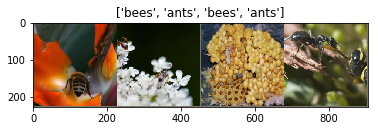

In [6]:
# вывод изображения
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# выводим очередную серию изображений    
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

Воспользуемся в данном случае оригинальным кодом шага обучения. Из новых вещей в нём -- параметр scheduler, **планировщик скорости обучения**, которая со временем должна снижаться.

Тут применяется такое интуитивное правило: когда скорость обучения высока, то модель будет обладать слишком высокой "кинетической энергией" -- вектор не будет уходить в достаточно узкие и глубокие локальные минимумы функции потерь. Но если скорость обучения была бы очень мала, то мы наоборот постоянно попадали бы в неглубокие и совсем узкие ложные минимумы функции потерь.

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Код визуализации прогнозов для различных тестовых изображений:

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Начинается основной код.

Воспользуемся готовой моделью ResNet (resnet18) с флажком pretrained, указывающим, что надо сразу использовать обученную модель, и тут же заменим её последний слой.

Настроим планировщик скорости обучения, как рекомендовано.

In [10]:
model_ft = models.resnet18(pretrained=True)

num_ftrs = model_ft.fc.in_features # model_ft.fc -- это слой Linear
model_ft.fc = nn.Linear(num_ftrs, 2) # подменяем оригинальный слой своим

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Будем уменьшать скорость обучения с коэффициентом 0.1 каждые 7 эпох
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 82109660.97it/s]


Запустим нашу модель на переобучение. 

**Предварительно укажите в настройках ноутбука поддержку GPU, иначе процесс может растянутся на десятки минут.**

In [11]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5993 Acc: 0.6762
val Loss: 0.1747 Acc: 0.9477

Epoch 1/24
----------
train Loss: 0.4418 Acc: 0.8033
val Loss: 0.2553 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.4557 Acc: 0.8074
val Loss: 0.1912 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.5956 Acc: 0.7500
val Loss: 0.2848 Acc: 0.8954

Epoch 4/24
----------
train Loss: 0.6342 Acc: 0.7623
val Loss: 0.3055 Acc: 0.8824

Epoch 5/24
----------
train Loss: 0.4761 Acc: 0.8033
val Loss: 0.3218 Acc: 0.8954

Epoch 6/24
----------
train Loss: 0.3577 Acc: 0.8484
val Loss: 0.2318 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.4217 Acc: 0.8361
val Loss: 0.2075 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.3286 Acc: 0.8443
val Loss: 0.2405 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.2864 Acc: 0.8566
val Loss: 0.2375 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.2811 Acc: 0.8770
val Loss: 0.2277 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.3025 Acc: 0.8689
val Loss: 0.2301 Acc: 0.9281

Ep

Получим примерно такие результаты с точностью около 90-95%:

Epoch 24/24
train Loss: 0.2861 Acc: 0.8770
val Loss: 0.2101 Acc: 0.9477

Training complete in 1m 33s
Best val Acc: 0.954248

Визуально проверим, как работает наша модель:


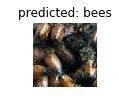

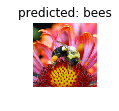

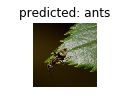

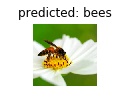

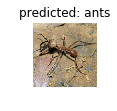

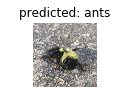

In [12]:
visualize_model(model_ft)

Теперь посмотрим, что получится, если веса оригинальной модели предварительно заморозить. Код остаётся тем же, за исключением сбрасывания флажка модели **requires_grad** (требование вычисления градиентов) в False.

In [0]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Скорость обучения модели теперь будет выше, потому что для большей части сети градиенты вычисляться уже не будут.


In [14]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5195 Acc: 0.7172
val Loss: 0.2155 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.4551 Acc: 0.7951
val Loss: 0.1798 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.5794 Acc: 0.7541
val Loss: 0.6846 Acc: 0.7516

Epoch 3/24
----------
train Loss: 0.7809 Acc: 0.6967
val Loss: 0.1838 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.4607 Acc: 0.8033
val Loss: 0.1976 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.6009 Acc: 0.7582
val Loss: 0.1844 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.3292 Acc: 0.8730
val Loss: 0.1680 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.4141 Acc: 0.8197
val Loss: 0.1815 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3300 Acc: 0.8484
val Loss: 0.1818 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3048 Acc: 0.8811
val Loss: 0.1949 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3459 Acc: 0.8689
val Loss: 0.1666 Acc: 0.9608

Epoch 11/24
----------
train Loss: 0.3716 Acc: 0.8238
val Loss: 0.1722 Acc: 0.9412

Ep

Epoch 24/24

train Loss: 0.3635 Acc: 0.8361
val Loss: 0.1871 Acc: 0.9542

Training complete in 1m 21s
Best val Acc: 0.960784

Как видно, результат получился немного получше.


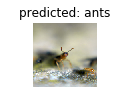

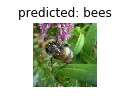

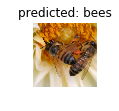

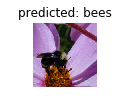

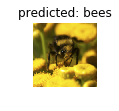

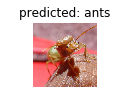

In [15]:
visualize_model(model_conv)

plt.ioff()
plt.show()

# **Задание**

Найдите небольшой датасет, подходящий для расширения ImageNet, с классом объектов, которого в ImageNet точно нету, и дообучите готовую модель на этом датасете. Какая точность у вас получится?

---

В следующем занятии займёмся участием в соревнованиях по машинному обучению на сервисе Kaggle.

##Решение